In [1]:
import matplotlib.pyplot as plt

sys.path.append(r'../atm_demand')
from feature_generation import *
from models import *

import pandas as pd
import tensorflow as tf
from scipy.special import softmax
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor, Pool

In [3]:
df = pd.read_csv("../atm_demand/DATA_sample_atm.csv")

all_atms_feature_set = get_all_atms_feature_set(df, first_n = 50)

all_atms_feature_set = add_cluster_features(all_atms_feature_set,
    [('Day_of_the_Week_Index', 20),
    ('Special_Lunar_Dates_Index', 5),
    ('Month_of_the_Year_Index', 20)],
    'CashIn', KMeans)
    
all_atms_feature_set.sort_index(inplace = True)

In [4]:
all_atms_feature_set.columns[:30]

Index(['CashIn', 'CashOut', 'AtmId', 'CashIn_average_7', 'CashIn_std_7',
       'CashIn_average_14', 'CashIn_std_14', 'CashIn_average_30',
       'CashIn_std_30', 'CashOut_average_7', 'CashOut_std_7',
       'CashOut_average_14', 'CashOut_std_14', 'CashOut_average_30',
       'CashOut_std_30', 'CashIn_trend_7', 'CashOut_trend_7', 'CashIn_t-1',
       'CashIn_t-2', 'CashIn_t-3', 'CashIn_t-4', 'CashIn_t-5', 'CashIn_t-6',
       'CashIn_t-7', 'CashIn_t-8', 'CashIn_t-9', 'CashIn_t-10', 'CashIn_t-11',
       'CashIn_t-12', 'CashIn_t-13'],
      dtype='object')

In [8]:
categorical_features = ['Day_of_the_Week_Index', 'Day_of_the_Month_Index',
       'Week_of_the_Year_Index', 'Month_of_the_Year_Index', 'Is_Weekday',
       'Special_Lunar_Dates_Index', 'Day_of_the_Week_Index_ClusterId',
       'Special_Lunar_Dates_Index_ClusterId', 'Month_of_the_Year_Index_ClusterId',
       'is_cocuk_bayrami', 'is_isci_bayrami', 'is_spor_bayrami',
       'is_zafer_bayrami', 'is_cumhuriyet_bayrami']
continuous_features   = ['CashIn_average_7', 'CashIn_std_7', 'CashIn_average_14',
       'CashIn_std_14', 'CashIn_average_30', 'CashIn_std_30',
       'CashOut_average_7', 'CashOut_std_7', 'CashOut_average_14',
       'CashOut_std_14', 'CashOut_average_30', 'CashOut_std_30',
       'CashIn_trend_7', 'CashOut_trend_7',
       'CashIn_t-1', 'CashIn_t-2', 'CashIn_t-3',
       'CashIn_t-4', 'CashIn_t-5', 'CashIn_t-6', 'CashIn_t-7', 'CashIn_t-8',
       'CashIn_t-9', 'CashIn_t-10', 'CashIn_t-11', 'CashIn_t-12',
       'CashIn_t-13', 'CashIn_t-14', 'CashOut_t-1', 'CashOut_t-2',
       'CashOut_t-3', 'CashOut_t-4', 'CashOut_t-5', 'CashOut_t-6',
       'CashOut_t-7', 'CashOut_t-8', 'CashOut_t-9', 'CashOut_t-10',
       'CashOut_t-11', 'CashOut_t-12', 'CashOut_t-13', 'CashOut_t-14',
       'CashOut_t-15', 'CashOut_t-16', 'CashOut_t-17', 'CashOut_t-18',
       'CashOut_t-19', 'CashOut_t-20', 'CashOut_t-21', 'CashOut_t-22',
       'CashOut_t-23', 'CashOut_t-24', 'CashOut_t-25', 'CashOut_t-26',
       'CashOut_t-27', 'CashOut_t-28']

all_features = []
all_features.extend(categorical_features)
all_features.extend(continuous_features)

X = all_atms_feature_set[all_features]
y = all_atms_feature_set['CashIn']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

train_pool = Pool(data = X_train, label = y_train, cat_features=categorical_features)

In [9]:
cb = CatBoostRegressor()
cb.fit(train_pool, verbose=0)

In [10]:
"Train score: %.2f, test score: %.2f" % (cb.score(X_train, y_train), cb.score(X_test, y_test))

'Train score: 0.77, test score: 0.65'

In [11]:
feature_importance = cb.get_feature_importance(train_pool)

In [12]:
feature_importance.reshape(1,-1).shape

(1, 82)

<AxesSubplot:xlabel='features'>

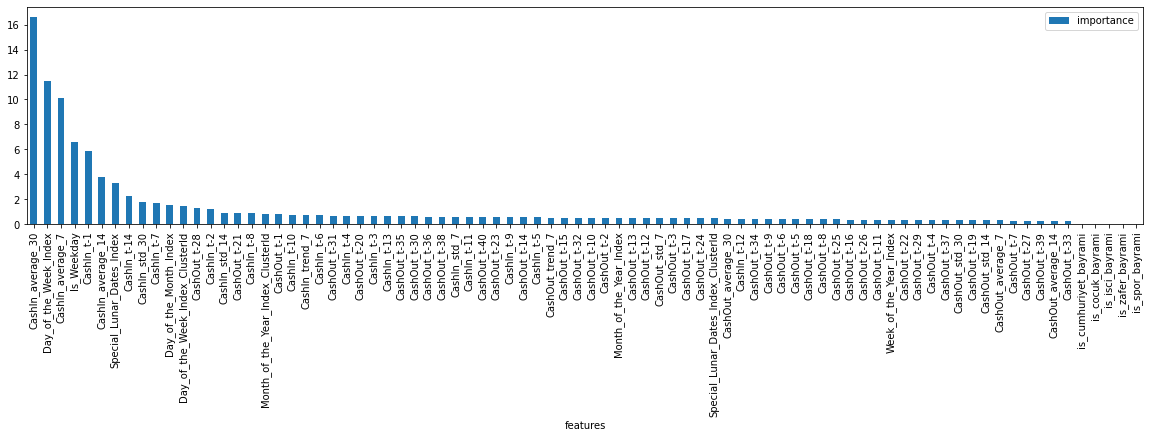

In [13]:
importance_df = pd.DataFrame({'features':all_features, 'importance':feature_importance})
importance_df.sort_values(by='importance', ascending=False, inplace=True)
importance_df.plot.bar(x='features', y='importance',figsize=(20,4))


## Plotting

In [14]:
from forecasting import get_error_with_freq
from plotting import draw_error_over_time

In [15]:
def draw_model_error(model, X, y_actual, error_freq='w', split_from=None):

    y_pred = pd.Series(model.predict(X).reshape(-1), index=y_actual.index)
    weekly_errors = get_error_with_freq(y_actual, y_pred, error_freq)
    draw_error_over_time(y_actual, y_pred, weekly_errors, split_from)
    print(weekly_errors.mean())

In [16]:
ATM_ID = 33821
atm_feature_set = all_atms_feature_set[all_atms_feature_set['AtmId'] == ATM_ID]
draw_model_error(cb, atm_feature_set[all_features], atm_feature_set['CashIn'], split_from=X_train.index[-1])

55.17331820923525
